In [1]:
import os
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nad.equip import intersect_gdf_with_equipments
from nad.flooding import get_flooded_area
from nad.load import (
    get_census_level,
    load_ageb_geometry,
    load_all_equipments,
    load_block_geometry,
    load_census,
)
from nad.traffic import calculate_tdpa_exposure

In [2]:
data_path = Path(os.environ["DATA_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
segregation_path = Path(os.environ["SEGREGATION_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])

results_path = Path("./results")
results_path.mkdir(exist_ok=True)

cache_path = Path("./cache")
cache_path.mkdir(exist_ok=True)

# Load

## Censo

In [3]:
df_census_base = load_census(census_path / "2020" / "08.csv")
df_census_agebs = get_census_level(df_census_base, level="ageb")
df_census_blocks = get_census_level(df_census_base, level="block")

## AGEBs

In [4]:
df_geom_agebs = load_ageb_geometry(
    population_grids_path / "final" / "zone_agebs" / "shaped" / "2020" / "08.2.03.gpkg",
)
df = df_geom_agebs.join(df_census_agebs, how="inner")

## Manzanas

In [5]:
df_geom_blocks = load_block_geometry(
    geostatistical_framework_path / "2020" / "08_chihuahua" / "08m.shp",
    ageb_cvegeos=df_geom_agebs.index,
)

df_blocks = df_geom_blocks.join(df_census_blocks, how="inner").assign(
    P_0A5=lambda df: df["P_0A2"] + df["P_3A5"],
)

## Equipamientos

In [6]:
df_equip = load_all_equipments(data_path)

# Stats

In [7]:
rows = {}

## Población, área y viviendas totales

In [8]:
rows["total_poblacion"] = df["POBTOT"]
rows["total_viviendas"] = df["TVIVPARHAB"]
rows["total_area_m2"] = df.to_crs("EPSG:6372")["geometry"].area

## Porcentaje población 0-5 años

In [9]:
rows["porcentaje_pob_0a5"] = (df["P_0A2"] + df["P_3A5"]) / df["POBTOT"]
rows["total_pob_0a5"] = df["P_0A2"] + df["P_3A5"]

## Porcentaje de población >60

In [10]:
rows["porcentaje_pob_60"] = df["P_60YMAS"] / df["POBTOT"]
rows["total_pob_60"] = df["P_60YMAS"]

## Porcentaje de población con menos de preparatoria terminada

In [11]:
rows["porcentaje_menos_prepa_terminada"] = 1 - df["P18YM_PB"] / df["P_18YMAS"]
rows["total_menos_prepa_terminada"] = df["P_18YMAS"] - df["P18YM_PB"]
rows["total_pob_18"] = df["P_18YMAS"]

## Ingreso

In [12]:
rows["ingreso"] = (
    gpd.read_file(segregation_path / "incomes" / "M08.04.gpkg")
    .rename(columns={"cvegeo": "CVEGEO"})
    .set_index("CVEGEO")["income_pc"]
)

In [13]:
columns = []
for key, value in rows.items():
    columns.append(value.rename(key))
out = pd.concat(columns, axis=1).join(df[["geometry"]])
out = gpd.GeoDataFrame(out, crs=df.crs, geometry="geometry")

## Equipamientos

In [14]:
df_equip = load_all_equipments(data_path)
temp = intersect_gdf_with_equipments(df, df_equip)

for col in temp.columns:
    rows[f"num_equip_{col}"] = temp[col]

df_equip.to_crs("EPSG:4326").to_file(
    results_path / "platform" / "equipamientos.geojson",
)

## Bienestar

In [15]:
rows["indice_bienestar"] = (
    gpd.read_file(data_path / "datos" / "bienestar.gpkg")
    .assign(CVEGEO=lambda df: df["CveGeo"])
    .set_index("CVEGEO")["NB_2020"]
    .replace(" ", np.nan)
)

## Marginacion

In [16]:
rows["indice_marginacion"] = (
    pd.read_excel(data_path / "datos" / "IMU_2020.xls", skiprows=5)
    .assign(CVEGEO=lambda df: df["CVE_AGEB"])
    .query("CVEGEO in @df.index")
    .set_index("CVEGEO")["GM_2020"]
)

## Industrias

In [17]:
harmful_industries = gpd.read_file(results_path / "harmful_industries.gpkg")
overlay = (
    harmful_industries[["geometry"]]
    .reset_index(names="index_left")
    .overlay(
        harmful_industries[["geometry"]].reset_index(names="index_right"),
        how="intersection",
    )
    .query("index_right != index_left")
    .assign(comb=lambda df: df[["index_left", "index_right"]].to_numpy().tolist())
    .assign(comb=lambda df: df["comb"].apply(lambda x: frozenset(x)))
    .dissolve("comb")
)

In [18]:
diff = harmful_industries.overlay(overlay, how="difference")

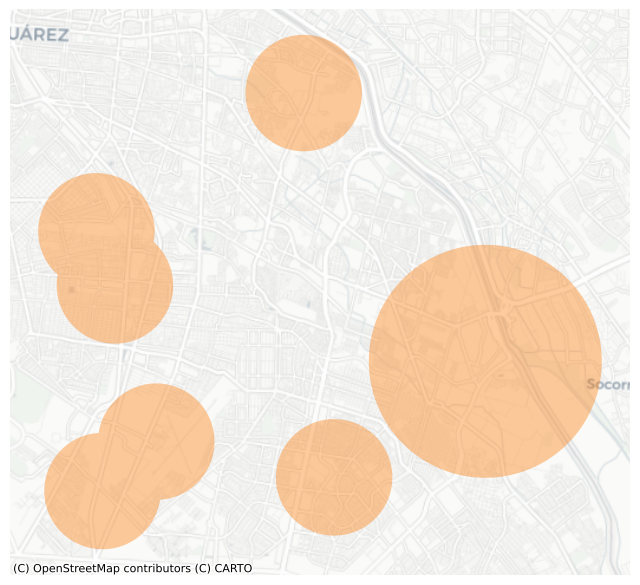

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
diff.plot(ax=ax, alpha=0.4, fc="C1")
overlay.plot(ax=ax, alpha=0.4, fc="C1")
ax.axis("off")
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=harmful_industries.crs)

In [20]:
df_agebs_affected = (
    df_blocks[["geometry", "CVEGEO_AGEB", "P_0A5", "P_60YMAS", "TVIVPARHAB"]]
    .sjoin(harmful_industries[["geometry"]], how="inner", predicate="within")
    .reset_index(names="CVEGEO")
    .drop_duplicates(subset="CVEGEO")
    .groupby("CVEGEO_AGEB")
    .agg({"P_0A5": "sum", "P_60YMAS": "sum", "TVIVPARHAB": "sum"})
)

rows["porcentaje_infantes_vulnerables_industria"] = (
    df_agebs_affected["P_0A5"] / df["P_0A5"]
).fillna(0)
rows["total_infantes_vulnerables_industria"] = df_agebs_affected["P_0A5"]

rows["porcentaje_adultos_mayores_vulnerables_industria"] = (
    df_agebs_affected["P_60YMAS"] / df["P_60YMAS"]
).fillna(0)
rows["total_adultos_mayores_vulnerables_industria"] = df_agebs_affected["P_60YMAS"]

rows["porcentaje_viviendas_vulnerables_industria"] = (
    df_agebs_affected["TVIVPARHAB"] / df["TVIVPARHAB"]
).fillna(0)
rows["total_viviendas_vulnerables_industria"] = df_agebs_affected["TVIVPARHAB"]

## Vulnerabilidad calor

In [21]:
rows["vulnerabilidad_calor"] = (
    gpd.read_file(data_path / "datos" / "GUHVI" / "agebs_GUHVI.gpkg")
    .set_index("cvegeo")["guhvi_class"]
    .astype(int)
)

## Accesibilidad

In [22]:
df_blocks_accessibility = gpd.read_file(
    results_path / "accessibility_blocks.gpkg",
).set_index("CVEGEO")

In [29]:
df_agebs_accessibility = (
    df_blocks_accessibility.groupby("CVEGEO_AGEB")
    .agg(
        {
            "accessibility_score": "mean",
            "tiempo_parque": "mean",
            "tiempo_clinica_hospital": "mean",
            "tiempo_preparatoria": "mean",
            "hogares_parque_15mi": "sum",
            "hogares_clinica_hospital_30mi": "sum",
            "hogares_preparatoria_30mi": "sum",
            "TVIVPARHAB": "sum",
        },
    )
    .assign(
        porcentaje_hogares_parque_15mi=lambda df: df.apply(
            lambda x: x["hogares_parque_15mi"] / x["TVIVPARHAB"]
            if x["TVIVPARHAB"] > 0
            else 0,
            axis=1,
        ),
        porcentaje_hogares_clinica_hospital_30mi=lambda df: df.apply(
            lambda x: x["hogares_clinica_hospital_30mi"] / x["TVIVPARHAB"]
            if x["TVIVPARHAB"] > 0
            else 0,
            axis=1,
        ),
        porcentaje_hogares_preparatoria_30mi=lambda df: df.apply(
            lambda x: x["hogares_preparatoria_30mi"] / x["TVIVPARHAB"]
            if x["TVIVPARHAB"] > 0
            else 0,
            axis=1,
        ),
    )
    .drop(columns=["TVIVPARHAB"])
    .rename(
        columns={
            "accessibility_score": "indice_accesibilidad",
            "hogares_parque_15mi": "total_hogares_parque_15min",
            "hogares_clinica_hospital_30mi": "total_hogares_clinica_hospital_30min",
            "hogares_preparatoria_30mi": "total_hogares_preparatoria_30min",
            "porcentaje_hogares_parque_15mi": "porcentaje_hogares_parque_15min",
            "porcentaje_hogares_clinica_hospital_30mi": "porcentaje_hogares_clinica_hospital_30min",
            "porcentaje_hogares_preparatoria_30mi": "porcentaje_hogares_preparatoria_30min",
        },
    )
)

for column in df_agebs_accessibility.columns:
    rows[column] = df_agebs_accessibility[column]

## Tráfico

In [30]:
gdf_vialidades = gpd.read_file(results_path / "vialidades.gpkg")

rows["tdpa_density"] = calculate_tdpa_exposure(
    df.rename_axis("id"),
    gdf_vialidades,
    threshold_km=500,
)

## Inundaciones

In [31]:
is_flooded = pd.read_csv(results_path / "flooded_blocks.csv").set_index("CVEGEO")[
    "is_flooded"
]

In [32]:
pop_flooded = (
    df_blocks.assign(is_flooded=pd.Series(is_flooded))
    .query("is_flooded")
    .groupby("CVEGEO_AGEB")["POBTOT"]
    .sum()
)

rows["total_poblacion_inundada"] = pop_flooded
rows["porcentaje_poblacion_inundada"] = (pop_flooded / df["POBTOT"]).fillna(0)

In [33]:
flooded_rows = []

flooded_df = get_flooded_area(
    data_path / "datos" / "CdJuarez_60min" / "CdJuarez_60Min_Reclass.tif",
    df,
)
rows["area_inundada_m2"] = flooded_df["flooded_area"]
rows["porcentaje_area_inundada"] = flooded_df["flooded_area_frac"]

# Out

In [46]:
out = gpd.GeoDataFrame(
    pd.DataFrame.from_dict(rows, orient="index").transpose().join(df[["geometry"]]),
    crs=df.crs,
    geometry="geometry",
).to_crs("EPSG:4326")

for c in out.columns:
    if c.startswith("indice") or c == "geometry":
        continue
    out[c] = out[c].astype(float)

out["indice_accesibilidad"] = out["indice_accesibilidad"].astype(float)

out.to_file(results_path / "platform" / "agebs.geojson")
out.drop(columns=["geometry"]).to_csv(results_path / "platform" / "agebs.csv")

<Axes: >

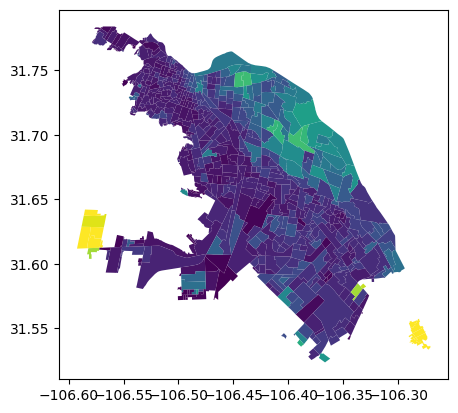

In [49]:
out.plot(column="indice_accesibilidad")